# BASTRA COMPARE SCENARIOS
Compares two traffic scenarios data analysis based on BASTRA simulator.

Author: Alvaro Paricio. sept.2016

## References
* For Wilcoxon tests:
    * http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html
    * https://gist.github.com/mblondel/1761714
    * http://www.randalolson.com/2012/08/06/statistical-analysis-made-easy-in-python/

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [67]:
# OPTIONS
flag_show_scenarios = True
flag_show_fleets = False
flag_show_heat_maps = False
flag_show_heat_maps_speed = False
flag_show_demand_stats = True
flag_show_traveltime_stats = True
flag_show_route_stats = True
flag_show_paired_stats = True
flag_show_paired_histo_secs = True
flag_show_paired_histo_perc = True
flag_show_paired_histo_usage = True
flag_show_paired_histo_cumsum = True
flag_paired_stats_save_csv = False
flag_display_gmaps = False

conf_paired_stats_confidence = 0.05
conf_single_stats_confidence = 0.05


In [3]:
## Scenarios setup

In [4]:
BASTRA_PATH="/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra"
label1="GRID16/MuTRAFF OFF/full traffic"
label2="GRID16/MuTRAFF ON/full traffic/1MAP/random5/logit100"

# Bastra L con 1 mapa
experiment1="grid16_noBastra_nomaps_fulltraffic_161114_125258"
experiment2="grid16_Bastra_rand05x1_timeALL_fulltraffic_logit05_161114_131513"

# Extra-Large con 2 lanes por edge + con 8 mapas
experiment1="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_190405"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_183734"


# Small con 8 mapas
experiment1="S_grid16_noBastra_reference_fulltraffic_161114_115215"
experiment2="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_114837"
experiment2="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_114102"

In [5]:
# Experimento con los 8 mapas puestos = pesos de referencia --> deberia dar lo mismo que sin Bastra o con reference maps
experiment1="S_grid16_noBastra_reference_fulltraffic_161114_115215"
experiment2="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_194134"

In [6]:
# Extra-Small para no saturar y 8 mapas random (500 + 4x200)
experiment1="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
experiment1="XS_grid16_noBastra_reference_fulltraffic_161114_223026"

experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit05_161115_092039"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit20_161115_092738"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093115"
experiment1="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093115"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_093432"



In [7]:
# 2 LANES con trafico grid16 normal (2000 + 4x200)
experiment1="grid16_noBastra_reference_fulltraffic_161115_110544"
# experiment1="XL2_grid16_noBastra_reference_fulltraffic_161115_092630"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093151"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_093621"


In [8]:
# 2 LANES con tráfico grid16 L (3000 + 4x200)
experiment1="grid16_noBastra_reference_fulltraffic_161115_164807"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_133434"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_134312"
experiment2="XL2_grid16_noBastra_reference_fulltraffic_161115_132611"


In [9]:
# A* Routing algorithms comparison
experiment1="grid16_noBastra_reference_fulltraffic_161115_192127"
experiment1="grid16_noBastraAstar_reference_fulltraffic_161115_191754"
experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit20_161115_222212"
experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit50_161115_223541"
experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit100_161115_225023"


In [10]:
# A* Routing algorithms comparison

# First experiments:
experiment1="grid16_noBastra_reference_fulltraffic_161115_192127"
experiment1="grid16_noBastraAstar_reference_fulltraffic_161115_191754"
#experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit20_161115_222212"
#experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit50_161115_223541"
#experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit100_161115_225023"

# Second experiments:
experiment1="grid16_noBastraAstar_reference_fulltraffic_161115_191754"
experiment1="grid16_noBastraAstar_reference_fulltraffic_161121_095357"
experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit20_161121_100716"
# experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit50_161121_101535"
# experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit100_161121_102631"


In [73]:
# ALCALA DE HENARES EXPERIMENTS
# alcalahenares_noBastra_nomaps_fulltraffic_161216_110525
# alcalahenares_L_Bastra_uni1x8_timeALL_fulltraffic_logit50_161216_114129
# alcalahenares_L_Bastra_uni5x8_timeALL_fulltraffic_logit50_161216_121730
# alcalahenares_L_Bastra_uni5x16_timeALL_fulltraffic_logit50_161216_153926

experiment1="alcalahenares_noBastra_nomaps_fulltraffic_161216_181131"
experiment2="alcalahenares_L_Bastra_uni1x8_timeALL_fulltraffic_logit50_161216_182824"

In [12]:
## IMPORTS

%matplotlib inline

import fileinput
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib as mpl
from IPython.display import display, HTML
# from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from scipy import stats as st

import sklearn as sk
import pandas as pd

In [13]:
### Functions

In [14]:
# Toggle CODE ON/OFF
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [15]:
# Reporting functions

idx1=0
idx2=0
idx3=0
def print_h0( title ):
    global idx1, idx2, idx3
    display(HTML("<h2>"+ title + "</h2>"))
    display(HTML("<style>div.output_subarea table {font-size: 10px;}</style>"))

    idx1 = 0
    idx2 = 0
    idx3 = 0

def print_h1( title, chapter ):
    global idx1, idx2, idx3
    idx1 +=1
    idx2 = 0
    idx3 = 0
    display(HTML("<h4>"+str(idx1)+". "+ title+". "+ chapter + "</h4>"))

def print_h2( title, chapter ):
    global idx1, idx2, idx3
    idx2 +=1
    idx3 = 0
    display(HTML("<h5>"+str(idx1)+"."+str(idx2)+". "+ title+". "+ chapter + "</h5>"))

def print_h3( title, chapter ):
    global idx1, idx2, idx3
    idx3 +=1
    display(HTML("<h6>"+str(idx1)+"."+str(idx2)+"."+str(idx3)+". "+ title+". "+ chapter + "</h6>"))


In [16]:
#### Function str_vals_percent
# Given two values, print them with their percent difference
def str_val( n ):
    return "{0:.2f}".format(n)
def str_perc( n1, n2 ):
    txt = "{0:.2f}".format((n2-n1)*100/n1) + "%"
    return txt
def str_vals_percent( n1, n2 ):
    return "[" + str_val(n1) + "," + str_val(n2) +"] "+ str_perc( n1, n2 ) 

In [17]:
#### Function dataset_obtain_unique_fleets
# Extract unique values for 'veh_types' column from the datasets.
#
# Support 0,1,2 datasets. Easy to extend to more dataserts. Not needed by now.
def dataset_obtain_unique_fleets( *ds ):
    size = len(ds)
    if( len(ds) == 0):
        return []
    if( len(ds) == 1):
        return ds[0]['veh_type'].unique()
    if( len(ds) == 2):
        vt1 = ds[0]['veh_type'].unique()
        vt2 = ds[1]['veh_type'].unique()
        return list(set().union(vt2, vt2))

In [18]:
#### Function dataset_filter_per_veh_type
# Filter a dataset per type of veh_type
def dataset_filter_per_veh_type(ds, vt):
    return ds.loc[ ds['veh_type']==vt ]

In [63]:
def compare_values(diff,op):
  if( diff==0):
    return "hasn't changed"
  if( op == '>'):
    return "has improved" if diff>0 else "gets worse"
  if( op == '<'):
    return "has improved" if diff<0 else "gets worse"
  return ""

#### Function printPairedStats
# Print paired statistics for two data sets
# Print Statistics for paired values
def printPairedStats( title, label1, ds_raw1, label2, ds_raw2 ):
    if( not flag_show_paired_stats ):
        return

    confidence_str = str(conf_paired_stats_confidence)+"%"
    # Copy DataFrames and change column names
    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ].copy()
    # WARNING: CHECK WITH THIS SENTENCE THAT EVERYTHIGN IS CORRECT: print(ds1.columns)
    ds1.columns = ['id1','veh_type1','t_depart_secs1','t_arrival_secs1','t_traveltime_secs1',
                   'origin1','destiny1', 'route_calc_num1',
                   'route_detail1','route_path_num1','route_distance1','is_attended1','has_finished1',
                   'maps1','tripfile1']
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ].copy()
    ds2.columns = ['id2','veh_type2','t_depart_secs2','t_arrival_secs2','t_traveltime_secs2',
                   'origin2','destiny2', 'route_calc_num2',
                   'route_detail2','route_path_num2','route_distance2','is_attended2','has_finished2',
                   'maps2','tripfile2']

    # Inner join for vehicles that completed in both scenarios
    ds3 = pd.merge(left=ds1,right=ds2, left_on='id1', right_on='id2')
    ds3['diff_traveltime_secs']=ds3['t_traveltime_secs1']-ds3['t_traveltime_secs2']
    # percent
    ds3['diff_traveltime_perc']=100.0*ds3['diff_traveltime_secs']/ds3['t_traveltime_secs1']

    # Inner join for vehicles that completed and used MUTRAFF in both scenarios
    # ds4 used Mutraff
    # ds5 didn't use Mutraff
    ds4 = ds3.loc[ ds3['is_attended2'] == True ].copy()
    ds5 = ds3.loc[ ds3['is_attended2'] == False ].copy()

    travel_times1 = ds3['t_traveltime_secs1']
    travel_times2 = ds3['t_traveltime_secs2']

    # --- VARIANCE COMPARISON STATISTICS
    x_t_test  = st.ttest_ind( travel_times1, travel_times2 )
    if( x_t_test.pvalue < conf_paired_stats_confidence ):
        x_t_test_str = "Variances are different (standard independent 2 sample test) "
    else:
        x_t_test_str = "We cannot assure that variances are equal"
    r_t_test  = st.ttest_ind( ds1['route_path_num1'], ds2['route_path_num2'])
    if( r_t_test.pvalue < conf_paired_stats_confidence ):
        r_t_test_str = "Variances are different (standard independent 2 sample test) "
    else:
        r_t_test_str = "We cannot assure that variances are equal"

    # SHAPIRO normality test
    diff_shapiro1_secs=st.shapiro(ds3['diff_traveltime_secs'])
    diff_shapiro1_perc=st.shapiro(ds3['diff_traveltime_perc'])
    diff_shapiro1_secs_str = ("Distrib is not normal" if diff_shapiro1_secs[1] < conf_paired_stats_confidence else "cannot reject that is normal")
    diff_shapiro1_perc_str = ("Distrib is not normal" if diff_shapiro1_perc[1] < conf_paired_stats_confidence else "cannot reject that is normal")

    # SIGN AND RANK SIGN WILCOXON TESTS
    diff_ranksign_test = st.wilcoxon( travel_times1, travel_times2 )
    diff_ranksign_test_str = ("Medians are sensitive different. MuTRAFF has a statistical significative impact" if diff_ranksign_test.pvalue < conf_paired_stats_confidence else "cannot reject that Medians are sensitive different")
    
    theStats = pd.DataFrame([
        [ 'Travel Time', 'T-TEST',  '(t_stat)(p_value)', confidence_str, x_t_test_str, 'stat='+str(x_t_test.statistic), 'p_val='+str(x_t_test.pvalue) ],
        [ 'Route Length', 'T-TEST',  '(t_stat)(p_value)', confidence_str, r_t_test_str, 'stat='+str(r_t_test.statistic), 'p_val='+str(r_t_test.pvalue) ],
        [ 'Travel Time', 'Wilcoxon Paired RankSign',  '', confidence_str, diff_ranksign_test_str, 'stat='+str(diff_ranksign_test.statistic), 'p_val='+str(diff_ranksign_test.pvalue) ],
        [ 'Diff in Travel Time', 'Shapiro',  '', confidence_str, r_t_test_str, 'stat='+str(r_t_test.statistic), 'p_val='+str(r_t_test.pvalue) ],
        [ 'Travel Time Diff secs', 'Shapiro Normality', 'secs', confidence_str, diff_shapiro1_secs_str, '', diff_shapiro1_secs[1] ],
        [ 'Travel Time Diff secs', 'mean',  't.units', confidence_str, compare_values(np.mean(ds3['diff_traveltime_secs']),'>'), np.mean(ds3['diff_traveltime_secs']), ''],
        [ 'Travel Time Diff secs', 'median',  't.units', confidence_str, compare_values(np.median(ds3['diff_traveltime_secs']),'>'),np.median(ds3['diff_traveltime_secs']), '' ],
        [ 'Travel Time Diff secs', 'std.deviation',  't.units', confidence_str, compare_values(np.std(ds3['diff_traveltime_secs']),'>'), np.std(ds3['diff_traveltime_secs']), '' ],
        [ 'Travel Time Diff %', 'Shapiro Normality', '%', '', diff_shapiro1_perc_str, '', diff_shapiro1_perc[1] ],
        [ 'Travel Time Diff %', 'mean',  '%', '', compare_values(np.mean(ds3['diff_traveltime_perc']),'>'), np.mean(ds3['diff_traveltime_perc']), ''],
        [ 'Travel Time Diff %', 'median',  '%', '', compare_values(np.median(ds3['diff_traveltime_perc']),'>'), np.median(ds3['diff_traveltime_perc']), '' ],
        [ 'Travel Time Diff %', 'std.deviation',  '%', '', compare_values(np.std(ds3['diff_traveltime_perc']),'>'), np.std(ds3['diff_traveltime_perc']), '' ],
        ])
    theStats.columns = [ '', 'Stat', 'Units', 'confidence', 'Analysis', 'stat', 'pvalue']
    print_h2(title,"PAIRED STATISTICS")
    display(HTML(theStats.to_html()))
    
    if( flag_show_paired_histo_secs ):
        print_h2(title,"PAIRED - Individual Absolute Traveltime Enhacenment histogram")
        cols = 80
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhacenment (time units)')
        plt.ylabel('Frecuency')
        plt.title("Individual travel time enhancement (time units)" )

        y_vals_secs, x_bins, patches = ax.hist(ds3['diff_traveltime_secs'], cols, normed=0, color=['blue'], alpha=0.30, histtype='bar')

        plt.show()

    if( flag_show_paired_histo_perc ):
        print_h2(title,"PAIRED - Individual Relative Traveltime Enhacenment histogram %")
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhacenment (%)')
        plt.ylabel('Frecuency')
        plt.title("Percentual Individual travel time enhancement (% enhancement relative to original travel time)" )

        # bins = np.linspace(-100, 100, 200)
        # y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], bins, normed=0, color=['blue'], alpha=0.30, histtype='bar')
        cols = 80
        y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], cols, normed=0, color=['blue'], alpha=0.30, histtype='bar')

        plt.show()

        # Percent Graphic zoom...
        bins = np.linspace(-100, 100, 200)
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhacenment (%)')
        plt.ylabel('Frecuency')
        plt.title("(Zoomed -100%,100%) Percentual Individual travel time enhancement (% enhancement relative to original travel time)" )
        y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], bins, normed=0, color=['blue'], alpha=0.30, histtype='bar')

        plt.show()
        if( flag_show_paired_histo_cumsum ):
            print_h2(title,"PAIRED - Cumulative distribution of Individual Traveltime Enhacenment")
            fig, ax = plt.subplots(figsize=(18,8))

            bins = len(y_vals)
            y_cum = np.cumsum(y_vals)
            y_cum_max = y_cum[bins-1]
            y_cum = y_cum/y_cum_max

            x1 = np.ones(bins)
            x_cum = np.cumsum(x1)
            #x_cum = x_cum/bins

            #print( "Enhancement differences (X):", x_cum )
            #print( "Enhancement differences (Y):", y_cum )

            plt.title("Cumulative distribution of Individual travel time enhancement" )
            plt.xlabel('Travel Time Enhacenment')
            plt.ylabel('Probability')
            # plot the cumulative function
            # plt.plot(base[:-1], cumulative, c='red')
            plt.plot(x_cum, y_cum, c='red')
            # plot the survival function
            # plt.plot(base[:-1], len(ds3['diff_traveltime_perc'])-cumulative, c='brown')
            plt.show()

    if( flag_show_paired_histo_usage ):
        print_h2(title,"PAIRED - MuTRAFF Usage - Individual absolute traveltime enhancement histogram")
        # Graph for Using Mutraff or not
        cols = 80
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhacenment based on MuTRAFF usage (time units)')
        plt.ylabel('Frecuency')
        plt.title("Individual travel time enhacenment (time units)" )

        ax.hist([ds4['diff_traveltime_secs'],ds5['diff_traveltime_secs']], cols, color=['green','red'], label=['Using MuTRAFF','Not using'], alpha=0.7, histtype='bar')      
        ax.grid(True)
        ax.legend(loc='upper right')
        plt.show()
        
        print_h2(title,"PAIRED - MuTRAFF Usage - Individual relative traveltime enhancement histogram")
        fig, ax = plt.subplots(figsize=(18,8))
        plt.xlabel('Travel Time Enhacenment (%)')
        plt.ylabel('Frecuency')
        plt.title("Percentual Individual travel time enhancement based on MuTRAFF usage(% enhancement relative to original travel time)" )

        cols = 80
        ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], cols, color=['green','red'], label=['Using MuTRAFF','Not using'], alpha=0.7, histtype='bar')
        ax.grid(True)
        ax.legend(loc='upper left')
        plt.show()

        # Percent Graphic zoom...
        bins = np.linspace(-100, 100, 100)
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhacenment (%)')
        plt.ylabel('Frecuency')
        plt.title("(Zoomed -100%,100%) Percentual Individual travel time enhancement based on MuTRAFF usage(% enhancement relative to original travel time)" )
        ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], bins, color=['green','red'], label=['Using MuTRAFF','Not using'], alpha=0.7, histtype='bar')
        ax.grid(True)
        ax.legend(loc='upper left')
        plt.show()

    if( flag_paired_stats_save_csv ):
        stats_file = '/tmp/mutraff-'+label1+"-"+label2+".csv"
        ds3.to_csv( stats_file )
        print( "Saved file " + stats_file )


In [20]:
#### Function draw_2histograms
# Plots the comparison between two overlapped histograms based on the datasets.
def draw_2histograms( title, label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 ):
    confidence_str = str(conf_single_stats_confidence)+"%"

    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ]
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ]
    ds3 = ds_raw2.loc[ ds_raw2['is_attended'] == True ]

    travel_times1 = ds1['t_traveltime_secs']
    travel_times2 = ds2['t_traveltime_secs']
    travel_times = [ travel_times1, travel_times2 ]

    cols = 80
    fig, ax = plt.subplots(figsize=(18,8))

    plt.xlabel('Travel Time')
    plt.ylabel('Frecuency')
    plt.title("Travel Times Histogram: "+label1+" <--> "+label2 )
    
    # y_vals1, x_bins1, patches1 = ax.hist(travel_times1, histtype='bar', cols, normed=0, facecolor='green', alpha=0.30)
    # y_vals2, x_bins2, patches2 = ax.hist(travel_times2, histtype='bar', cols, normed=0, facecolor='blue', alpha=0.30)
    [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'blue'], alpha=0.30, histtype='bar')
    
    conf_int=0.68
    
    # first histogram ------------------------------------
    x_size1   = len(travel_times1)
    x_mean1   = np.mean(travel_times1)
    x_median1 = np.median(travel_times1)
    x_std1    = np.std(travel_times1)
    x_var1    = np.var(travel_times1)
    x_conf_int1  = st.norm.interval(conf_int, loc=x_mean1, scale=x_std1)
    x_m_conf_int1= st.norm.interval(conf_int, loc=x_mean1, scale=x_std1/np.sqrt(x_size1))
    x_shapiro1=st.shapiro(travel_times1)
    x_shapiro_str1 = confidence_str + ("is not normal" if x_shapiro1[1] < conf_single_stats_confidence else "cannot reject that is normal")
    y_mean1   = np.mean(y_vals1)
    y_median1 = np.median(y_vals1)
    y_std1    = np.std(y_vals1)
    r_mean1   = np.mean(ds1['route_path_num'])
    r_median1 = np.median(ds1['route_path_num'])
    r_std1    = np.std(ds1['route_path_num'])
    r_var1    = np.var(ds1['route_path_num'])
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_m_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1/np.sqrt(x_size1))
    # l_mean1   = np.mean(ds1['route_length'])
    # l_median1 = np.median(ds1['route_length'])
    l_mean1   = 1
    l_median1 = 1

    # add a 'best fit' line
    y1_vals1 = np.append( y_vals1, y_vals1[cols-1] )

    x2_mean1   = [ x_mean1   for i in y1_vals1 ]
    x3_median1 = [ x_median1 for i in y1_vals1 ]
    y2_mean1   = [ y_mean1   for i in x_bins ]
    y3_median1 = [ y_median1 for i in x_bins ]

    # second histogram ------------------------------------
    x_size2   = len(travel_times2)
    x_mean2   = np.mean(travel_times2)
    x_median2 = np.median(travel_times2)
    x_std2    = np.std(travel_times2)
    x_var2    = np.var(travel_times2)
    x_conf_int2  = st.norm.interval(conf_int, loc=x_mean2, scale=x_std2)
    x_m_conf_int2= st.norm.interval(conf_int, loc=x_mean2, scale=x_std2/np.sqrt(x_size2))
    x_shapiro2=st.shapiro(travel_times2)
    x_shapiro_str2 = confidence_str + ("is not normal" if x_shapiro2[1] < conf_single_stats_confidence else "cannot reject that is normal")
    y_mean2   = np.mean(y_vals2)
    y_median2 = np.median(y_vals2)
    y_std2    = np.std(y_vals2)
    r_mean2   = np.mean(ds2['route_path_num'])
    r_median2 = np.median(ds2['route_path_num'])
    r_std2    = np.std(ds2['route_path_num'])
    r_var2    = np.var(ds2['route_path_num'])
    r_conf_int2  = st.norm.interval(conf_int, loc=r_mean2, scale=r_std2)
    r_m_conf_int2= st.norm.interval(conf_int, loc=r_mean2, scale=r_std2/np.sqrt(x_size2))
    r_t_test  = st.ttest_ind( ds1['route_path_num'], ds2['route_path_num'])
    # l_mean2   = np.mean(ds2['route_length'])
    # l_median2 = np.median(ds2['route_length'])
    l_mean2   = 1
    l_median2 = 1
     
    # add a 'best fit' line
    y1_vals2 = np.append( y_vals2, y_vals2[cols-1] )

    x2_mean2   = [ x_mean2   for i in y1_vals2 ]
    x3_median2 = [ x_median2 for i in y1_vals2 ]
    y2_mean2   = [ y_mean2   for i in x_bins ]
    y3_median2 = [ y_median2 for i in x_bins ]

    if( flag_show_demand_stats ):
      theStats = pd.DataFrame([
        [ 'Trips Planned', 'num',  'trips', str_perc(ds_raw1['id'].count(),ds_raw2['id'].count()), ds_raw1['id'].count(), ds_raw2['id'].count()],
        [ 'Trips Routed',  'num',  'trips', str_perc(travel_times1.count(),travel_times2.count()), travel_times1.count(), travel_times2.count()],
        [ 'Trips using MuTRAFF',  'num',  'trips', str_perc(travel_times1.count(),len(ds3)), travel_times1.count(), len(ds3)],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      print_h2(title, "NON-PAIRED STATS - ROUTED DEMAND")
      display(HTML(theStats.to_html()))

    if( flag_show_traveltime_stats ):
      theStats = pd.DataFrame([
        [ 'Travel Time', 'mean',  't.units', str_perc(x_mean1,x_mean2), x_mean1, x_mean2 ],
        [ 'Travel Time', 'median',  't.units', str_perc(x_median1,x_median2), x_median1, x_median2 ],
        # [ 'Travel Time', 'variance',  't.units', str_perc(x_var1,x_var2), x_var1, x_var2 ],
        [ 'Travel Time', 'std.deviation',  't.units', str_perc(x_std1,x_std2), x_std1,x_std2 ],
        [ 'Travel Time', 'Value Confidence Interval',  't.units', '', str(x_conf_int1), str(x_conf_int2) ],
        [ 'Travel Time', 'Mean Confidence Interval',  't.units', '', str(x_m_conf_int1), str(x_m_conf_int2) ],
        [ 'Travel Time', 'Shapiro', '', '', x_shapiro_str1, x_shapiro_str2 ]
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]
      print_h2(title, "NON-PAIRED STATS - TRAVELTIME")
      display(HTML(theStats.to_html()))

    if( flag_show_route_stats ):
      theStats = pd.DataFrame([
        [ 'Route Length', 'mean',  'mts', str_perc(r_mean1,r_mean2), r_mean1, r_mean2 ],
        [ 'Route Length', 'median',  'mts', str_perc(r_median1,r_median2), r_median1, r_median2 ],
        # [ 'Route Length', 'variance',  'mts', str_perc(r_var1,r_var2), r_var1, r_var2 ],
        [ 'Route Length', 'std.deviation',  'mts', str_perc(r_std1,r_std2), r_std1, r_std2 ],
        [ 'Route Length', 'Value Confidence Interval',  'mts', '', str(r_conf_int1), str(r_conf_int2) ],
        [ 'Route Length', 'Mean Confidence Interval',  'mts', '', str(r_m_conf_int1), str(r_m_conf_int2) ],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      print_h2(title, "NON-PAIRED STATS - ROUTE LENGTH")
      display(HTML(theStats.to_html()))

    print_h2(title, "NON-PAIRED STATS - TRAVELTIMES COMPARED HISTOGRAM")
    line_estimation1 = ax.plot(x_bins, y1_vals1, 'r-', label='Estimation', linewidth=2, color='darkgreen')
    line_estimation2 = ax.plot(x_bins, y1_vals2, 'r-', label='Estimation', linewidth=2, color='darkblue')

    max_y = np.linspace(0, max( max(y_vals1), max(y_vals2)), num=len(x_bins))
    line_mean1 = ax.plot(x2_mean1, max_y, label='Mean', linestyle='--', linewidth=2, color='darkgreen')
    line_median1 = ax.plot(x3_median1, max_y, label='Median', linestyle='-', linewidth=2, color='darkgreen')

    line_mean2 = ax.plot(x2_mean2, y1_vals2, label='Mean', linestyle='--', linewidth=2, color='darkblue')
    line_median2 = ax.plot(x3_median2, max_y, label='Median', linestyle='-', linewidth=2, color='darkblue')

    mean_line1   = mlines.Line2D([], [], linestyle='--',color='darkgreen', markersize=1, label=label1+':Mean')
    median_line1 = mlines.Line2D([], [], linestyle='-', color='darkgreen', markersize=1, label=label1+':Median')
    mean_line2   = mlines.Line2D([], [], linestyle='--',color='darkblue',  markersize=1, label=label2+':Mean')
    median_line2 = mlines.Line2D([], [], linestyle='-', color='darkblue',  markersize=1, label=label2+':Median')
    ax.legend(handles=[median_line1, mean_line1, median_line2, mean_line2], loc='upper right')
    # plt.axis([travel_times.min(), travel_times.max()+1, 0, 0.03])
    ax.grid(True)

    # If plotting OUTSIDE the notebook, set interactive mode ON/OFF
    # plt.ioff()
    # plt.ion()

    plt.show()

In [21]:
#### Function map_coord
# Maps edge coordinates into a grid representation for heatmaps.
# Receives as input parameters:
#    * (x,y) values to be mapped
#    * (max, min)(x,y) value ranges for x,y
#    * grid dimensions
# Test code to create distribution in array of heatmap
def map_coord(x,y,min_x,max_x,min_y,max_y,dim_x,dim_y):
    c_x = int(x/(max_x-min_x)*dim_x)
    c_y = int(y/(max_y-min_y)*dim_y)
    # print( "(x,y):(", x, ":", y, ") --> coords:(", c_x, ",", c_y, ")")
    return [ c_x, c_y ]

In [22]:
def subplot_heatmap(title, column, criteria, heatmap, scale_min, scale_max, vals, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y):
    max_v = vals[column].max()
    min_v = vals[column].min()

    heatmap.grid(True)
    heatmap.set_title(title+" / min:"+str(min_v)+", max:"+str(max_v) )
    vmap = np.zeros( (grid_size_x,grid_size_y) )
    for i in range(len(vals)):
        x, y = map_coord( vals.ix[i,'av_x'], vals.ix[i,'av_y'],
                    x_min,x_max,y_min,y_max, grid_size_x, grid_size_y )
        vals.ix[i,'canvas_x'] = x
        vals.ix[i,'canvas_y'] = y
        # METHOD: AGGREGATE VALUES 
        # OTHER METHODS WOULD BE POSSIBLE !!!
        if( criteria.lower() == 'max' ):
            if( vals.ix[i,column]> vmap[x,y] ):
                vmap[x,y] = vals.ix[i,column]
        else:
            if( criteria.lower() == 'min' ):
                if( vals.ix[i,column]< vmap[x,y] ):
                    vmap[x,y] = vals.ix[i,column]
            else:
                # Additive critieria:
                vmap[x,y] += vals.ix[i,column]
        
        # if( values.ix[i,column] > 0.1 ):
        #  print( "{:d} : {:d},{:d} = {:f} <-- {:f},{:f}".format(
        #        i, x, y, values.ix[i,column], values.ix[i,'av_x'], values.ix[i,'av_y']),
        #        "...", canvas_x_min,canvas_x_max,canvas_y_min,canvas_y_max, size_x, size_y )
    hot_vals = pd.DataFrame( vmap )
    # print(values[['canvas_x','canvas_y',column,'av_x','av_y']].sort_values(by=column,ascending=False))
    
    # interploation='bilinear', 'bicubic', 'nearest'
    # other colormaps are also possible such as: 'Reds'
    img = heatmap.imshow( hot_vals, cmap='YlOrBr', interpolation='bicubic', vmin=scale_min, vmax=scale_max)
    return img

In [23]:
#### Function plot_traffic_heatmap
# Creates a heatmap plot for a given variable in a determinate time epoch. Considers only data coming from this epoch.
#Input parameters:
#    * Plot title
#    * Traffic network edges (as map representation)
#    * Edge dat sets obtained
#    * Size of the heatmap grid to be represented
#    * Time epoch to be considered
def plot_traffic_heatmap_single( title, edges, edge_ds_1, edge_ds_2, column, criteria, grid_size_x, grid_size_y, epoch ):

    # Extract the columns edge and <<measure>>
    ds1 = edge_ds_1.loc[ edge_ds_1['time']==epoch ][['edge_id',column]]
    ds2 = edge_ds_2.loc[ edge_ds_2['time']==epoch ][['edge_id',column]]
    
    # merge with edge coordinates
    values1 = pd.merge(ds1, edges, how='left', left_on=['edge_id'], right_on=['name'])
    values2 = pd.merge(ds2, edges, how='left', left_on=['edge_id'], right_on=['name'])
    
    # print(values)
    max_v1 = values1[column].max()
    max_v2 = values2[column].max()
    min_v1 = values1[column].min()
    min_v2 = values2[column].min()
    max_v = max( [ max_v1, max_v2 ] )
    min_v = min( [ min_v1, min_v2 ] )

    #Calculate canvas axis x,y over the whole map
    edge_vals_x = edges[['x1','x2']]
    x_min = edge_vals_x.values.min()
    x_max = edge_vals_x.values.max()
    
    edge_vals_y = edges[['y1','y2']]
    y_min = edge_vals_y.values.min()
    y_max = edge_vals_y.values.max()
    # print("VALUES","min:", min_v, " max:",max_v)
    # print("X_AXIS","min:", canvas_x_min, " max:",canvas_x_max)
    # print("Y_AXIS","min:", canvas_y_min, " max:",canvas_y_max)

    fig, heatmaps = plt.subplots(1, 2, figsize=(20,8) )
    # fig, heatmaps = plt.subplots(1, 2 )
    fig.suptitle( title+". Time: "+str(epoch) )
    # plt.figure(figsize=(20,8))
    im = subplot_heatmap(column, column, criteria, heatmaps[0], min_v, max_v,
                    values1, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    im = subplot_heatmap(column,  column, criteria, heatmaps[1], min_v, max_v,
                    values2, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    
    fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar_ax = fig.add_axes()
    # fig.colorbar(im, cax=cbar_ax)
    cax,kw = mpl.colorbar.make_axes([ax for ax in heatmaps.flat])
    plt.colorbar(im, cax=cax, **kw)
    plt.show()

In [24]:
def plot_traffic_heatmap( title, edge_map, edge_stats1, edge_stats2, measure, criteria, grid_size_x, grid_size_y, graphic_samples ):

    times = edge_stats1.time.unique()
    graphic_step = int((len(times)-1)/graphic_samples)
    # print("=== COMPARING",measure,"in", graphic_samples, "steps")

    for t in range(0,graphic_samples):
        timestamp = times[t*graphic_step]
        print (measure+"[time:"+str(timestamp)+"]" )
        plot_traffic_heatmap_single( "Halted vehicles (num)", edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, timestamp )

    plot_traffic_heatmap_single( "Halted vehicles (num)", edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, times[len(times)-1] )

In [25]:
#### Function compare_scenarios
# Uploads results from 2 scenario executions and plotting the histogram curves based on the dataset.
# * Select only those vehicles that finish the trip, i.e. have arrive time > 0.
def load_scenario_data( path, label, experiment ):
    expr = re.compile('^__.+')
    data={}
    # print( "Scenario: ", label, "\nExperiment: ", experiment, "\n" )
    descriptor = path + "/experiments/tmp/" + experiment + "/SCENARIO_DESCRIPTION.md"
    # print( "FILE:", descriptor, "\n")
    data['TITLE']=label
    data['EXPERIMENT']=experiment
    for line in fileinput.input([descriptor]):
        if( expr.match(line) ):
            [key,val] = line.rstrip().split("=")
            data[key]=val
    return data
    
def print_scenarios( path, label1, experiment1, label2, experiment2 ):
    par1 = load_scenario_data(path, label1, experiment1)
    par2 = load_scenario_data(path, label2, experiment2)
    df = pd.DataFrame([par1, par2]).T
    df.columns = ['exp1','exp2']
    display(HTML(df.to_html()))
    return df


# GOOGLE MAPS INTEGRATION
# http://jupyter-gmaps.readthedocs.io/en/latest/authentication.html
# https://github.com/pbugnion/gmaps

import gmaps
import gmaps.datasets
import os
# Alvaro GMAPS API KEY - DONT REUSE IT IF YOU ARE NOT ALVARO !!!!!
# gmaps_api_key="xxxxxxxx"
gmaps_api_key=os.environ["GOOGLE_API_KEY"]
gmaps.configure(api_key=gmaps_api_key)

def plot_gmaps( title, edge_map1, edge_stats1, edge_stats2 ):
    if( not flag_display_gmaps ):
        return
    #print_h3(title, "CONGESTION - EDGE TRAVELTIMES")
    print_h3(title, "CONGESTION - EDGE HALTED VEHICLES")
    locations = gmaps.datasets.load_dataset("starbucks_uk")
    print( "Locations:", locations)
    m = gmaps.Map()
    starbucks_layer = gmaps.symbol_layer(
            locations, fill_color="green", stroke_color="green", scale=2)
    m.add_layer(starbucks_layer)
    m
    #print_h3(title, "CONGESTION - EDGE SPEEDS")
    print( "--- FIN ---")

In [26]:

def compare_scenarios( path, lab1, experiment1, lab2, experiment2 ):
    print_h0("EXPERIMENT SCENARIOS COMPARISON")

    if( flag_show_scenarios ):
        df = print_scenarios( BASTRA_PATH, lab1, experiment1, lab2, experiment2 )

    datafile1 = path + "/experiments/tmp/" + experiment1 + "/" + experiment1 + ".csv"
    datafile2 = path + "/experiments/tmp/" + experiment2 + "/" + experiment2 + ".csv"
    label1 = lab1
    label2 = lab2
    label1 = df.loc['__PREFIX','exp1']
    label2 = df.loc['__PREFIX','exp2']
    # print( "DATAFILE: ", datafile )
    # ds means "dataset"
    ds_raw1 = pd.read_csv(datafile1)
    ds_raw2 = pd.read_csv(datafile2)
    veh_types = dataset_obtain_unique_fleets( ds_raw1, ds_raw2 )

    print_h1("GLOBAL TRAFFIC","STATISTICS")
    draw_2histograms( "GLOBAL TRAFFIC",
                      label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 )
    # Print Statistics for paired values
    printPairedStats( "GLOBAL TRAFFIC", label1, ds_raw1, label2, ds_raw2 )

    if( flag_show_fleets ):
      if ( len(veh_types) > 0 ):
        for vt in veh_types:
          ds_raw1b = dataset_filter_per_veh_type(ds_raw1, vt)
          ds_raw2b = dataset_filter_per_veh_type(ds_raw2, vt)
          # ds_raw1b.head()
        
          print_h1("FLEET: "+vt,"STATISTICS")
          draw_2histograms( "FLEET: "+vt,
                    label1, experiment1, ds_raw1b, label2, experiment2, ds_raw2b )
          # Print Statistics for paired values
          printPairedStats( "FLEET: "+vt, label1, ds_raw1b, label2, ds_raw2b )
    
    edge_map_file1 = path + "/experiments/tmp/" + experiment1 + "/edges.csv"
    edge_map1 = pd.read_csv( edge_map_file1)
    edge_stats_file1 = path + "/experiments/tmp/" + experiment1 + "/edge_stats.csv"
    edge_stats1 = pd.read_csv( edge_stats_file1)
    edge_stats_file2 = path + "/experiments/tmp/" + experiment2 + "/edge_stats.csv"
    edge_stats2 = pd.read_csv( edge_stats_file2)

    # print(label1, " / ", label2)
    if( flag_show_heat_maps ):
      # print("=== ROAD EDGE STATISTICS COLLECTED:", edge_stats1.columns.values.tolist())
      graphic_samples = 10
    
      print_h2("GLOBAL TRAFFIC", "GEOGRAPHICAL DENSITIES DISTRIBUTIONS")

      measure = 'traf_av_occupancy'
      print_h3("GLOBAL TRAFFIC", "CONGESTION - EDGE TRAVELTIMES")
      plot_traffic_heatmap( "Congestion (traveltime)", edge_map1,
                             edge_stats1, edge_stats2, measure, "max",
                             32,32, graphic_samples )

        
      measure = 'traf_halted_veh_num'
      print_h3("GLOBAL TRAFFIC", "CONGESTION - EDGE HALTED VEHICLES")
      plot_traffic_heatmap( "Halted vehicles (num)", edge_map1,
                             edge_stats1, edge_stats2, measure, "add",
                             16,16, graphic_samples )

      if( flag_show_heat_maps_speed ):
        measure = 'traf_av_speed'
        print_h3("GLOBAL TRAFFIC", "CONGESTION - EDGE SPEEDS")
        plot_traffic_heatmap( "Mean speed (m/s)", edge_map1,
                               edge_stats1, edge_stats2, measure, "min",
                               16,16, graphic_samples )
    # print_h2("GLOBAL TRAFFIC", "GOOGLE MAPS")
    # plot_gmaps( "GLOBAL TRAFFIC", edge_map1, edge_stats1, edge_stats2 )

,exp1,exp2
EXPERIMENT,alcalahenares_noBastra_nomaps_fulltraffic_1612...,alcalahenares_L_Bastra_uni1x8_timeALL_fulltraf...
TITLE,GRID16/MuTRAFF OFF/full traffic,GRID16/MuTRAFF ON/full traffic/1MAP/random5/lo...
__BASTRA_FORESIGHT_HALTING,0,0
__BASTRA_FORESIGHT_PENALTY,1,1
__BASTRA_FORESIGHT_STEPS,0,0
__BASTRA_FORESIGHT_TRIES,0,0
__BASTRA_LOGIT,1,50
__BASTRA_USE_BALANCE,false,true
__GRID_SIZE,16,16
__LANES,1,1


,,Stat,Units,variation,alcalahenares_noBastra_nomaps_fulltraffic,alcalahenares_L_Bastra_uni1x8_timeALL_fulltraffic_logit50
0,Trips Planned,num,trips,0.00%,9250,9250
1,Trips Routed,num,trips,0.77%,3639,3667
2,Trips using MuTRAFF,num,trips,27.92%,3639,4655


,,Stat,Units,variation,alcalahenares_noBastra_nomaps_fulltraffic,alcalahenares_L_Bastra_uni1x8_timeALL_fulltraffic_logit50
0,Travel Time,mean,t.units,-3.07%,1681.89,1630.28
1,Travel Time,median,t.units,3.40%,1117,1155
2,Travel Time,std.deviation,t.units,-3.98%,1436.24,1379.07
3,Travel Time,Value Confidence Interval,t.units,,"(253.61072343005935, 3110.1694359543872)","(258.84484594808282, 3001.7054676597713)"
4,Travel Time,Mean Confidence Interval,t.units,,"(1658.2133273572117, 1705.5668320272343)","(1607.6277600279341, 1652.9225535799196)"
5,Travel Time,Shapiro,,,0.05%is not normal,0.05%is not normal


,,Stat,Units,variation,alcalahenares_noBastra_nomaps_fulltraffic,alcalahenares_L_Bastra_uni1x8_timeALL_fulltraffic_logit50
0,Route Length,mean,mts,1.65%,22.3822,22.7513
1,Route Length,median,mts,0.00%,16,16
2,Route Length,std.deviation,mts,3.28%,14.0591,14.5206
3,Route Length,Value Confidence Interval,mts,,"(8.4010187274309533, 36.363477013157123)","(8.3111869185787253, 37.191403754996408)"
4,Route Length,Mean Confidence Interval,mts,,"(22.150479415262296, 22.614016325325778)","(22.512835633624487, 22.989755039950641)"


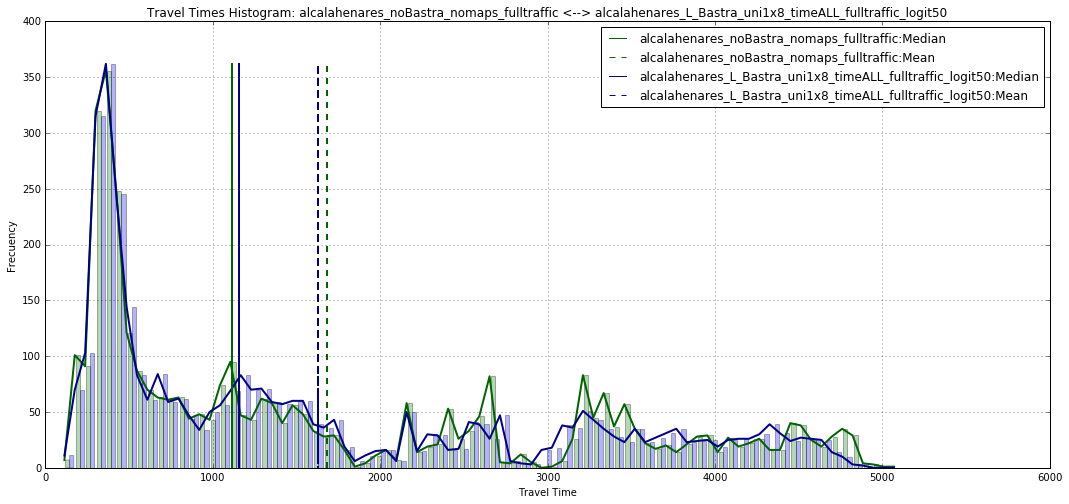

,,Stat,Units,confidence,Analysis,stat,pvalue
0,Travel Time,T-TEST,(t_stat)(p_value),0.05%,We cannot assure that variances are equal,stat=0.82832494368,p_val=0.407540777063
1,Route Length,T-TEST,(t_stat)(p_value),0.05%,We cannot assure that variances are equal,stat=-1.10336153628,p_val=0.269906543694
2,Travel Time,Wilcoxon Paired RankSign,,0.05%,Medians are sensitive different. MuTRAFF has a...,stat=563111.0,p_val=4.27544102229e-19
3,Diff in Travel Time,Shapiro,,0.05%,We cannot assure that variances are equal,stat=-1.10336153628,p_val=0.269906543694
4,Travel Time Diff secs,Shapiro Normality,secs,0.05%,Distrib is not normal,,0
5,Travel Time Diff secs,mean,t.units,0.05%,has improved,38.3974,
6,Travel Time Diff secs,median,t.units,0.05%,has improved,4,
7,Travel Time Diff secs,std.deviation,t.units,0.05%,has improved,225.027,
8,Travel Time Diff %,Shapiro Normality,%,,Distrib is not normal,,0
9,Travel Time Diff %,mean,%,,has improved,0.522663,


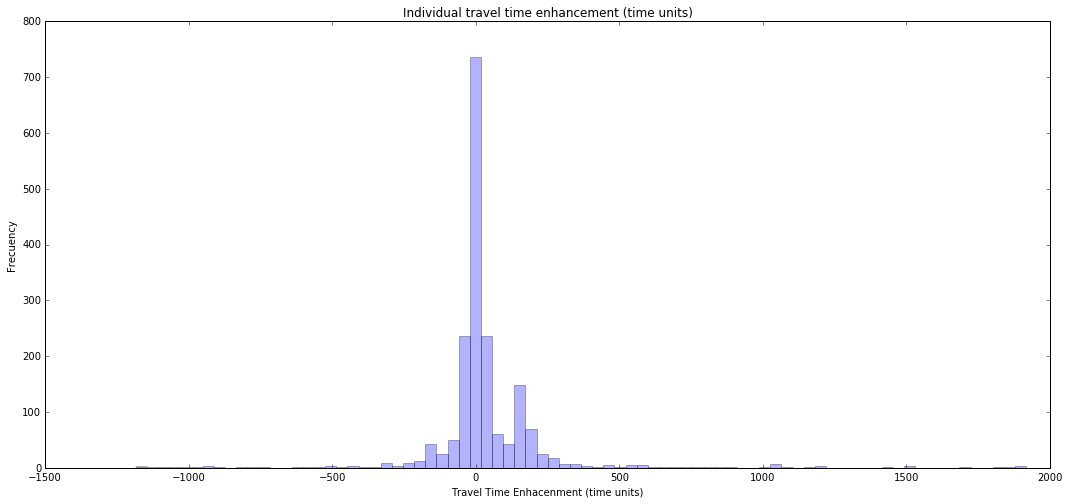

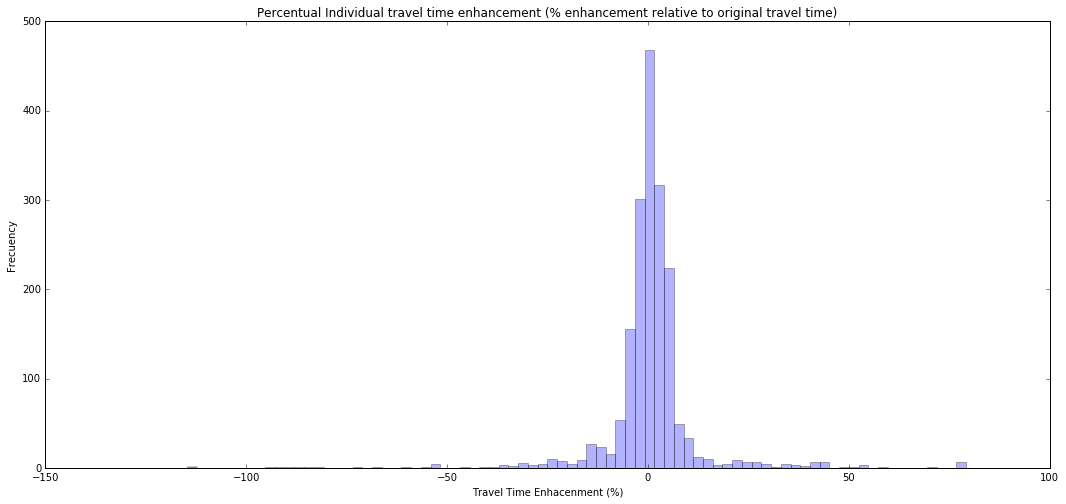

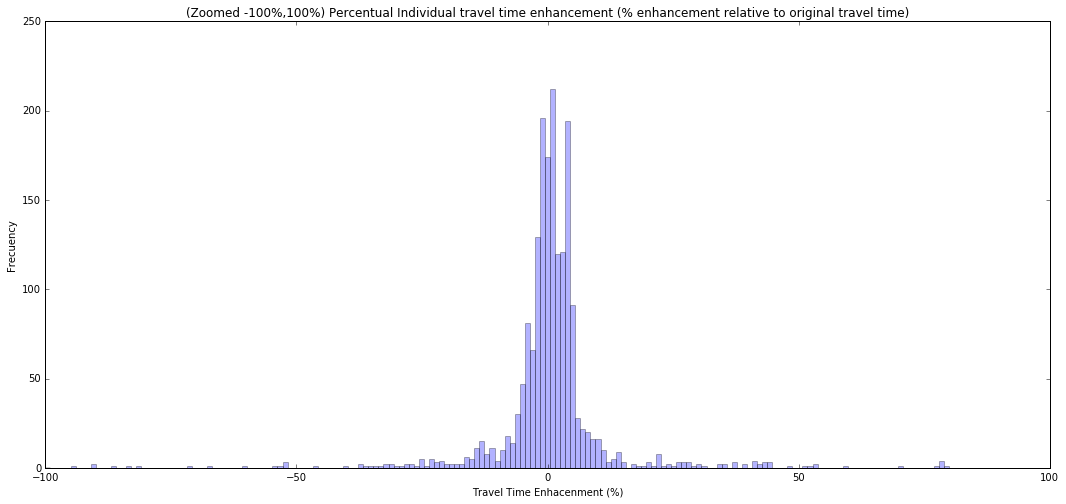

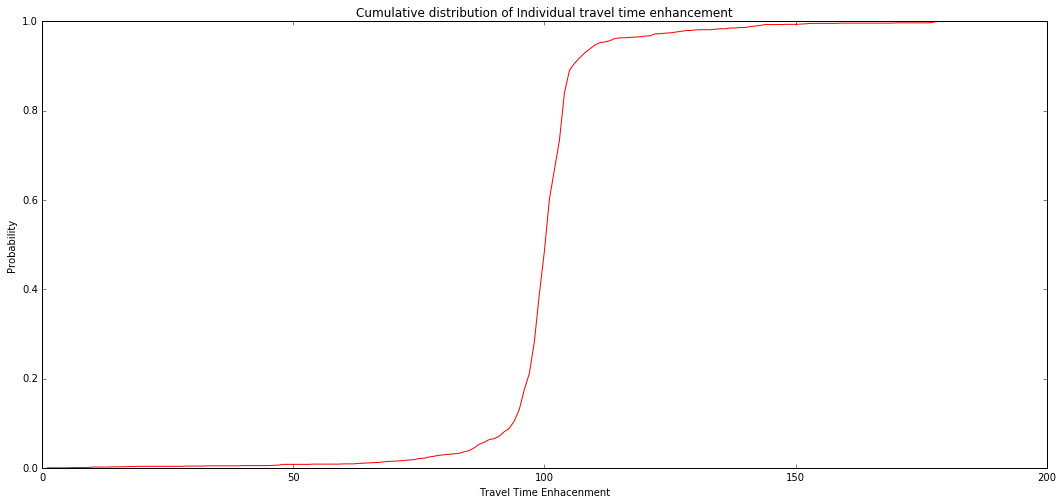

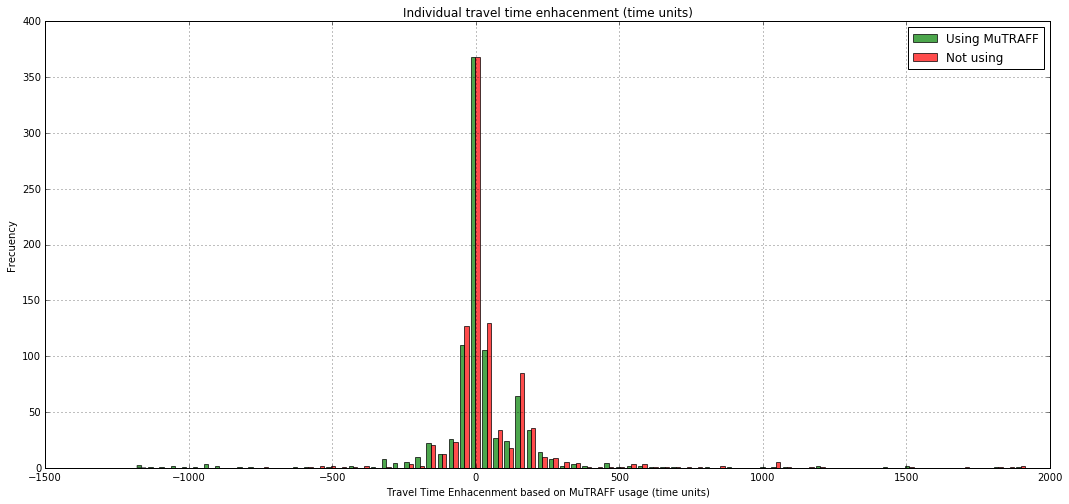

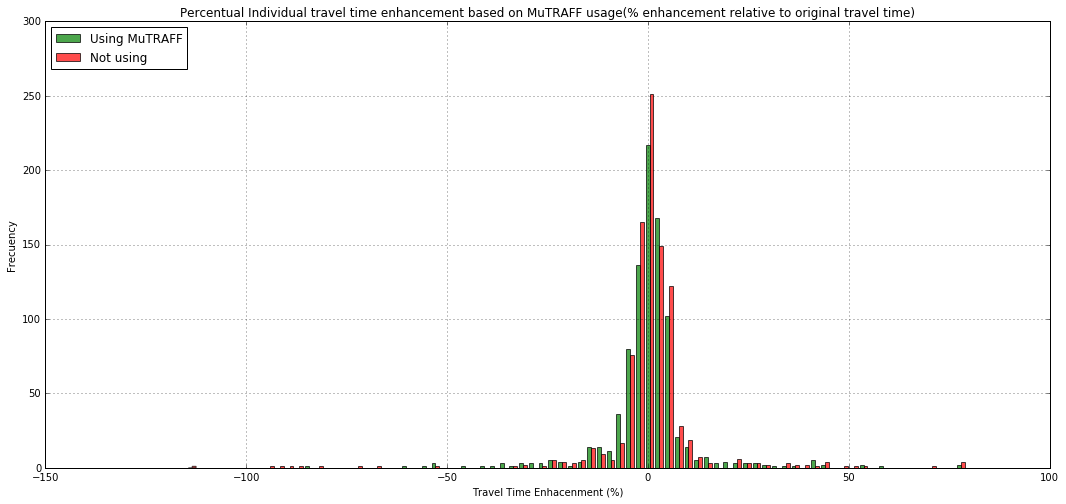

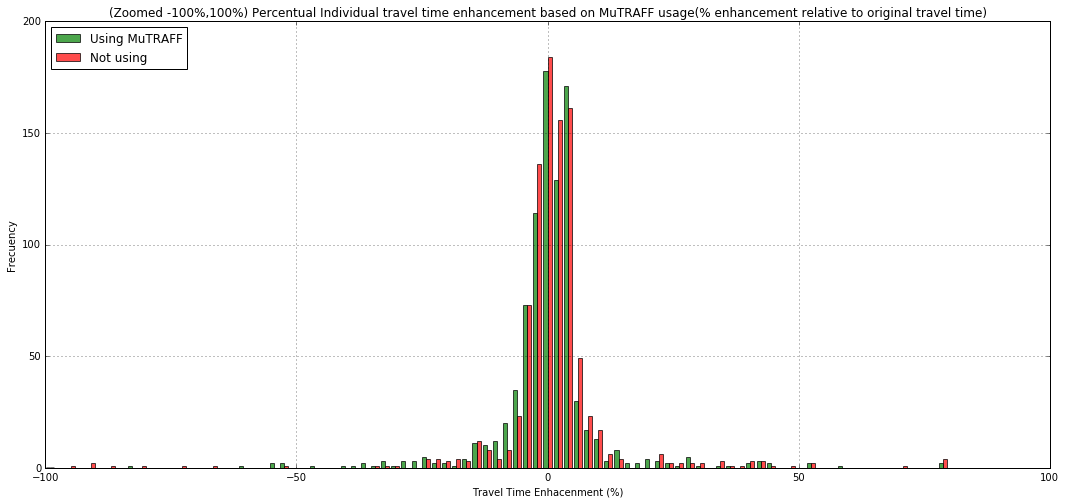

OSError: File b'/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra/experiments/tmp/alcalahenares_noBastra_nomaps_fulltraffic_161216_181131/edge_stats.csv' does not exist

In [74]:
compare_scenarios( BASTRA_PATH, label1, experiment1, label2, experiment2 )

# BACKUP